# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg,year, month, dayofmonth,dayofweek,countDistinct
from pyspark.sql.types import StringType, IntegerType, DateType,DoubleType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum,mean,max,min
import pyspark.sql.functions as func
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,NaiveBayes,DecisionTreeClassifier;
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;


import datetime as dt
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("projekt") \
    .getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
#df.printSchema()

In [4]:
# checking for missing values 
# In total
df_notna = df.na.drop()

df_cnt = df.count()
notna_cnt = df_notna.count()
df_cnt - notna_cnt
# df has 58392 rows with missing values

df.filter(df.userId == '').count()
## There are 8346 rows with black userId

8346

In [5]:
# unique userIds and sessionIds
all_users = df.select('userId').dropDuplicates()
all_sessions = df.select('sessionId').dropDuplicates()
all_users.count()

226

In [15]:
# filter for users with blank user id
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

all_pages = df.select('page').dropDuplicates()
#find values in all_pages that are not in blank_pages
#these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Roll Advert
Submit Downgrade
Add to Playlist
Cancel
Thumbs Up
Save Settings
Thumbs Down
Downgrade
Submit Upgrade
Upgrade
Logout
Add Friend
NextSong
Cancellation Confirmation
Settings


# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [6]:
# choose userId not blank
df = df.filter(df.userId != " ")

# In our dataset we have 52 visits of the page Cancellation Confirmation
df.filter(df.page == 'Cancellation Confirmation').count()

52

In [7]:
## Show all unique pages 
df.select("page").distinct().show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



## 2.1. Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [8]:
# Beside the definition for churn, I create further variables for each userstatus
churn = udf(lambda x : int(x == 'Cancel'), IntegerType())
downgrade = udf(lambda x : int(x == 'Downgrade'), IntegerType())
downgraded = udf(lambda x: 1 if (x == "Submit Downgrade") else 0, IntegerType())
submit_cancel = udf(lambda x : int(x == 'Cancellation Confirmation'), IntegerType())
upgrade = udf(lambda x : int(x == 'Upgrade'), IntegerType())
upgraded = udf(lambda x : int(x == 'Submit Upgrade'), IntegerType())

df = df.withColumn("submit_cancel", submit_cancel("page")) \
    .withColumn("submit_downgrade",downgraded("page"))\
    .withColumn("submit_upgrade",upgraded("page"))\
    .withColumn("visit_cancel",churn("page"))\
    .withColumn("visit_downgrade",downgrade("page"))\
    .withColumn("visit_upgrade",upgrade("page"))


In [9]:
# List of churned and downgraded users for exploration purpose in the next part
churn_user = df.filter(df.submit_cancel==1).select("userId").dropDuplicates()
churn_userlist = churn_user.rdd.map(lambda row : row[0]).collect() # as list 

dgrade_user = df.filter(df.submit_downgrade==1).select("userId").dropDuplicates()
dgrade_userlist = dgrade_user.rdd.map(lambda row : row[0]).collect() # as list 

## data of churned or downgraded users
churn_dgrade_user = df.filter(df.userId.isin(churn_userlist)|df.userId.isin(dgrade_userlist))

## 2.2. Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 2.2.1 Churn vs. level

+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|            userId|    user_downgraded|     user_cancelled|         user_churn|   user_downgrade|     user_upgraded|      user_upgrade|
+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|               226|                226|                226|                226|              226|               226|               226|
|   mean|65391.013333333336|0.27876106194690264|0.23008849557522124|0.23008849557522124|  9.0929203539823|0.7035398230088495|2.2079646017699117|
| stddev|105396.47791907164| 0.5866592919890465|0.42182354515228027|0.42182354515228027|11.72405858292471|0.7337488766346668|2.5571039727845033|
|    min|                  |                  0|                  0|                  0|                0|                 0|     

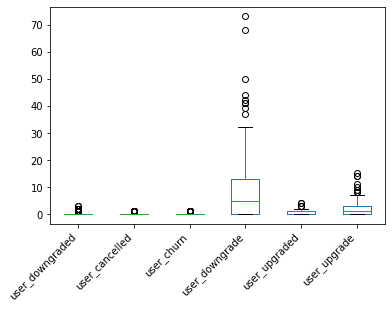

In [10]:
## Describe the submit_cancel and downgraded info per user
## sum up all changes of status for each user
status_sum = df.select(['userId', 'submit_downgrade', 'submit_cancel','visit_cancel','visit_downgrade',"submit_upgrade","visit_upgrade",'level'])\
            .groupBy(['userId'])\
            .sum()\
            .withColumnRenamed('sum(submit_downgrade)','user_downgraded') \
            .withColumnRenamed('sum(submit_cancel)','user_cancelled')\
            .withColumnRenamed('sum(submit_upgrade)','user_upgraded')\
            .withColumnRenamed('sum(visit_upgrade)','user_upgrade') \
            .withColumnRenamed('sum(visit_cancel)','user_churn') \
            .withColumnRenamed('sum(visit_downgrade)','user_downgrade')

status_sum.describe().show()
status_sum.toPandas().plot.box();
plt.xticks(rotation=45, ha='right');

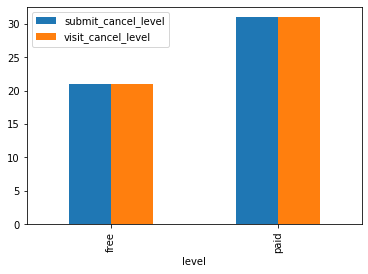

In [11]:
## dummy level
free = udf(lambda level : int(level == 'free'), IntegerType())
paid = udf(lambda level : int(level == 'paid'), IntegerType())

df = df.withColumn('free',free('level'))\
    .withColumn('paid',paid('level'))

## status by level 
status_by_level = df.select(['userId', 'submit_downgrade', 'submit_cancel','visit_cancel','visit_downgrade',"submit_upgrade","visit_upgrade",'level'])\
            .groupBy(['level'])\
            .sum()\
            .withColumnRenamed('sum(submit_downgrade)','submit_downgrade_level') \
            .withColumnRenamed('sum(submit_cancel)','submit_cancel_level')\
            .withColumnRenamed('sum(submit_upgrade)','submit_upgrade_level')\
            .withColumnRenamed('sum(visit_upgrade)','visit_upgrade_level') \
            .withColumnRenamed('sum(visit_cancel)','visit_cancel_level') \
            .withColumnRenamed('sum(visit_downgrade)','visit_downgrade_level')

statusplot = status_by_level.toPandas()
statusplot.plot.bar(x="level", y=["submit_cancel_level","visit_cancel_level"]);

### 2.2.2 Churn vs weekday/day

In [12]:
# Convert timestamp to datetime format
todate = udf(lambda x :  dt.datetime.fromtimestamp(x/1000), DateType())
gethour = udf(lambda x :  dt.datetime.fromtimestamp(x/1000).hour, IntegerType())
df = df.withColumn('date',todate('ts'))\
    .withColumn('year',year(todate('ts')))\
    .withColumn('month',month(todate('ts')))\
    .withColumn('day',dayofmonth(todate('ts')))\
    .withColumn('hour',gethour('ts'))\
    .withColumn('weekday',dayofweek(todate('ts')))

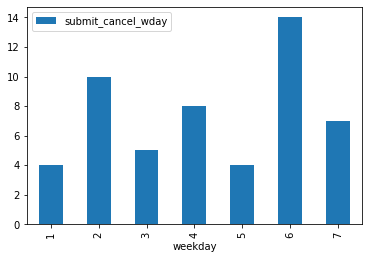

In [13]:
# churn by weekday
churn_by_wday = df.select(['userId', 'submit_cancel','weekday'])\
            .groupBy(['weekday'])\
            .sum()\
            .withColumnRenamed('sum(submit_cancel)','submit_cancel_wday') \
            .orderBy("weekday")\
            .drop('sum(weekday)')

plot_churnwday = churn_by_wday.toPandas()
plot_churnwday.plot.bar(x="weekday");


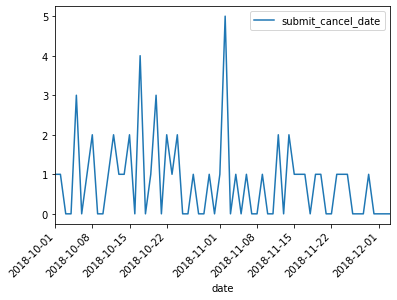

In [14]:
# churn by date
churn_by_date = df.groupBy(['date'])\
            .sum()\
            .withColumnRenamed('sum(submit_cancel)','submit_cancel_date') \
            .withColumnRenamed('sum(visit_cancel)','visit_cancel_date') \
            .withColumnRenamed('sum(submit_downgrade)','submit_downgrade_date') \
            .withColumnRenamed('sum(visit_downgrade)','visit_downgrade_date')\
            .withColumnRenamed('sum(itemInSession)','items') \
            .withColumnRenamed('sum(length)','length') \
            .orderBy("date")

churn_by_date.toPandas().plot.line(x="date",y=["submit_cancel_date"])
plt.xticks(rotation=45, ha='right');

### 2.2.3 Churn vs. number of sessions

+------+------------------+
|userId|       avg_session|
+------+------------------+
|200002|               1.0|
|100010|               1.0|
|   125|               1.0|
|    51|1.2142857142857142|
|   124|1.2222222222222223|
|     7|               1.0|
|    15|1.1111111111111112|
|    54|1.5161290322580645|
|   155|             1.125|
|   132|1.0909090909090908|
|100014|               1.0|
|   154|               1.0|
|    11|            1.0625|
|   101|1.2307692307692308|
|300017| 1.469387755102041|
|   138|1.1578947368421053|
|    29|1.4827586206896552|
|100021|               1.0|
|    69|               1.0|
|    42|1.3777777777777778|
+------+------------------+
only showing top 20 rows



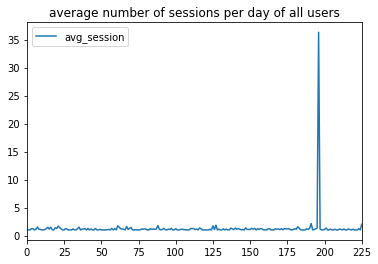

In [26]:
## number of sessions per user per day
num_session = df.groupBy("userId","date").agg(countDistinct("sessionId").alias('num_session_date'))\
            .dropDuplicates()\
            .orderBy(desc("num_session_date"))
avg_session = num_session.groupBy("userId").agg(mean("num_session_date").alias("avg_session")).dropDuplicates()

avg_session.show()

avg_session.toPandas().plot()
plt.title("average number of sessions per day of all users")
plt.show()

In [27]:
avg = avg_session.toPandas()
avg.query("avg_session >5") 
# userId 196 has abnormal number of sessions per day, there is probably a technical problem

,userId,avg_session
196,,36.322581


### 2.2.4 Churn vs. average number of items in sessions by weekday

In [28]:
window_level = Window.partitionBy(["submit_cancel","weekday"])

## average item in sessions by weekday
avg_item = df.withColumn("avg_item",mean("itemInSession").over(window_level))\
            .select(["weekday","avg_item","submit_cancel"])\
            .dropDuplicates()\
            .orderBy("weekday")
avg_item.show()

plot_avg_item = avg_item.toPandas()
plot_avg_item.groupby("submit_cancel").avg_item.describe()

+-------+------------------+-------------+
|weekday|          avg_item|submit_cancel|
+-------+------------------+-------------+
|      1|127.55207808275672|            0|
|      1|             78.75|            1|
|      2| 89.00668787590274|            0|
|      2|              48.0|            1|
|      3|              99.4|            1|
|      3|115.99617256729209|            0|
|      4|122.38731391051186|            0|
|      4|           104.875|            1|
|      5|             100.0|            1|
|      5|108.98646563505709|            0|
|      6| 95.92857142857143|            1|
|      6|113.60968211599126|            0|
|      7|101.71428571428571|            1|
|      7| 135.3343695228017|            0|
+-------+------------------+-------------+



,count,mean,std,min,25%,50%,75%,max
submit_cancel,,,,,,,,
0,7.0,116.124681,14.896865,89.006688,111.298074,115.996173,124.969696,135.33437
1,7.0,89.809694,20.299044,48.000000,87.339286,99.400000,100.857143,104.87500


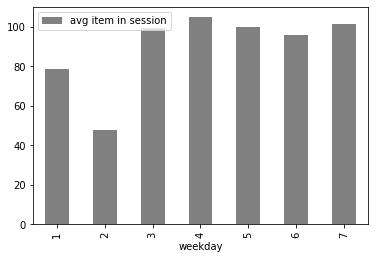

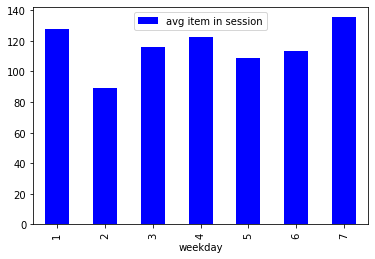

In [29]:
plot_avg_item.query("submit_cancel==1").plot.bar(x="weekday",y="avg_item",color = "grey",label="avg item in session")
plot_avg_item.query("submit_cancel==0").plot.bar(x="weekday",y="avg_item",color = "blue",label="avg item in session");

### 2.2.5 Churn vs. number of songs users listen to on average between visiting our home page

In [30]:
# filter out 0 sum and max sum to get more exact answer
# function from lesson 3
#

homevisit = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

window_usertime= Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('level','userId', 'page', 'ts','date','hour','submit_cancel','submit_downgrade','visit_cancel','visit_downgrade') \
    .withColumn('homevisit', homevisit(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(window_usertime))

num_songs = cusum.filter(cusum.page == 'NextSong') \
    .groupBy('userId', 'period') \
    .agg({'period':'count'})\
    .withColumnRenamed('count(period)','num_songs_period')

avg_num_songs = num_songs.groupBy('userId').agg({'num_songs_period':'avg'})\
        .withColumnRenamed('avg(num_songs_period)','avg_songs_period')

In [31]:

## filter on churn user 
## average songs churn user listen to on average between home visits
cusum.filter((cusum.userId.isin(churn_userlist))&(cusum.page == 'NextSong')) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'})\
    .withColumnRenamed('avg(count(period))','churn_avg_songs_homevisit').show()

## average songs downgrade user listen to on average between home visits
cusum.filter((cusum.userId.isin(dgrade_userlist))&(cusum.page == 'NextSong')) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'})\
    .withColumnRenamed('avg(count(period))','dgrade_avg_songs_homevisit').show()

+-------------------------+
|churn_avg_songs_homevisit|
+-------------------------+
|         22.6612702366127|
+-------------------------+

+--------------------------+
|dgrade_avg_songs_homevisit|
+--------------------------+
|        23.510264721772014|
+--------------------------+



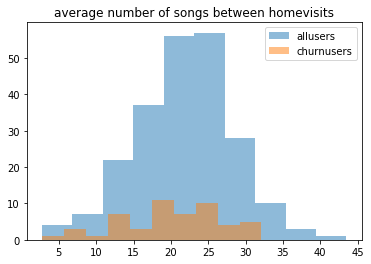

count    225.000000
mean      21.819982
std        6.550401
min        2.750000
25%       17.777778
50%       22.231481
75%       25.342105
max       43.500000
Name: avg_songs_period, dtype: float64

In [32]:
## plot
churn_avg_songs = avg_num_songs.filter(avg_num_songs.userId.isin(churn_userlist))
x = avg_num_songs.toPandas().avg_songs_period
y = churn_avg_songs.toPandas().avg_songs_period
plt.hist(x,label="allusers",alpha = 0.5)
plt.hist(y,alpha = 0.5,label="churnusers")
plt.legend(loc='upper right')
plt.title("average number of songs between homevisits")
plt.show()
avg_num_songs.toPandas().avg_songs_period.describe()

In [33]:
churn_avg_songs.toPandas().avg_songs_period.describe()

count    52.000000
mean     20.167316
std       6.673541
min       2.750000
25%      16.750000
50%      20.750000
75%      24.930373
max      32.125000
Name: avg_songs_period, dtype: float64

### 2.2.6 Churn vs. length per session

In [34]:
window_session= Window.partitionBy('userId','sessionId') \
    .orderBy(df['ts'].desc()) \
    .rangeBetween(Window.unboundedPreceding,0)

window_usersession= Window \
    .partitionBy('userId','sessionId')
window_user= Window \
    .partitionBy('userId')


session_len = df\
.withColumn('sessiontime',
            ((func.max(df['ts']/3600000).over(window_session) - (func.min(df['ts']/3600000).over(window_session)))))

session = session_len\
        .withColumn("avg_session",mean('sessiontime').over(window_usersession))\
        .withColumn("max_session",max('sessiontime').over(window_usersession))\
        .withColumn("min_session",min('sessiontime').over(window_usersession))


session_user = session\
            .withColumn("avg_session_user",mean('sessiontime').over(window_user))\
            .withColumn("max_session_user",max('sessiontime').over(window_user))\
            .withColumn("min_session_user",min('sessiontime').over(window_user))\
            .select(["userId","submit_cancel","avg_session_user","max_session_user","min_session_user"]).dropDuplicates()


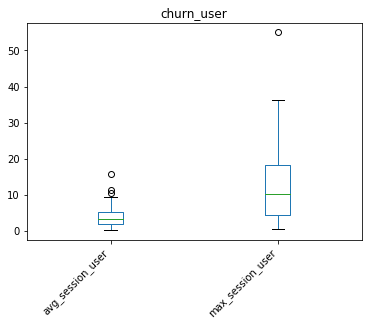

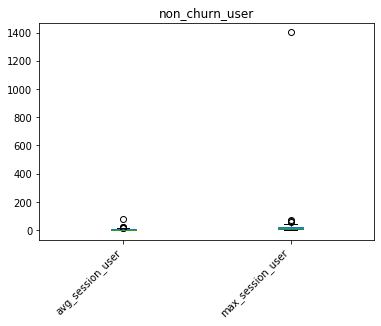

In [35]:
plot_session_user = session_user.toPandas()
plot_session_user.query("submit_cancel==1").plot.box(title="churn_user",y=["avg_session_user","max_session_user"])
plt.xticks(rotation=45, ha='right');
plot_session_user.query("submit_cancel==0").plot.box(title="non_churn_user",y=["avg_session_user","max_session_user"])
plt.xticks(rotation=45, ha='right');

In [36]:
plot_session_user.query("submit_cancel==1").describe()

,submit_cancel,avg_session_user,max_session_user,min_session_user
count,52.0,52.000000,52.000000,52.0
mean,1.0,4.009100,13.015657,0.0
std,0.0,3.165271,11.002779,0.0
min,1.0,0.172273,0.492778,0.0
25%,1.0,1.752687,4.484931,0.0
50%,1.0,3.290508,10.249722,0.0
75%,1.0,5.073975,18.347361,0.0
max,1.0,15.723832,55.000278,0.0


In [37]:
plot_session_user.query("submit_cancel==0").describe()

,submit_cancel,avg_session_user,max_session_user,min_session_user
count,226.0,226.000000,226.000000,226.0
mean,0.0,5.112401,22.261340,0.0
std,0.0,5.922357,92.898006,0.0
min,0.0,0.070833,0.116667,0.0
25%,0.0,2.360630,6.723056,0.0
50%,0.0,4.116589,14.154861,0.0
75%,0.0,6.819254,23.686528,0.0
max,0.0,77.833712,1400.940833,0.0


### 2.2.7 Churn vs. gender

In [38]:
user_gender = df.replace(["M", "F"], ["0", "1"], "gender") #dummy gender
user_gender = user_gender.select("userId", user_gender.gender.cast("int")).dropDuplicates()


user_gender.filter((user_gender.userId.isin(churn_userlist))& (user_gender.gender == 0))\
.agg({"userId":"count"})\
.withColumnRenamed("count(userId)",'churn_male').show()
user_gender.filter((user_gender.userId.isin(churn_userlist))& (user_gender.gender == 1))\
.agg({"userId":"count"})\
.withColumnRenamed("count(userId)",'churn_female').show()

+----------+
|churn_male|
+----------+
|        32|
+----------+

+------------+
|churn_female|
+------------+
|          20|
+------------+



### 2.2.8 Churn vs. playlist

+------+--------------------------+
|userId|avg_songs_playlist_session|
+------+--------------------------+
|100010|         54.42857142857143|
|200002|                      79.0|
|   125|                      11.0|
|    51|                     246.4|
|   124|         166.3793103448276|
|     7|        28.714285714285715|
|    54|         92.89189189189189|
|    15|        151.86666666666667|
|   155|                     167.0|
|100014|        51.666666666666664|
|   132|                     144.0|
|   154|        39.333333333333336|
|   101|                     214.9|
|    11|                      53.0|
|300017|         70.28571428571429|
|   138|                     164.6|
|    29|        105.97058823529412|
|    69|        149.11111111111111|
|100021|                      63.8|
|    42|         90.57446808510639|
+------+--------------------------+
only showing top 20 rows



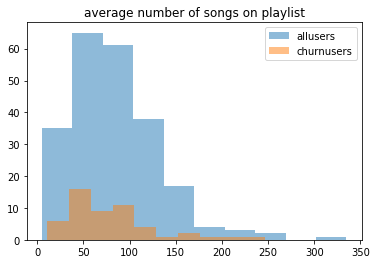

count    226.000000
mean      84.475111
std       49.249298
min        5.123389
25%       47.835714
50%       79.375000
75%      110.902174
max      334.888889
Name: avg_songs_playlist_session, dtype: float64

In [39]:
playlist = udf(lambda playlist : int(playlist == 'Add to Playlist'), IntegerType())
add_playlist = df.withColumn('playlist', playlist(col('page'))) 


num_playlist =add_playlist.groupBy('userId','sessionId') \
    .agg({'playlist':'count'}) \
    .withColumnRenamed('count(playlist)','number_songs_playlist')

avg_playlist = num_playlist.groupby("userId").agg({"number_songs_playlist":"mean"})\
            .withColumnRenamed('avg(number_songs_playlist)','avg_songs_playlist_session')
avg_playlist.show()

# average number of songs added to playlist of the churn users vs. all users

churn_avg_playlist = avg_playlist.filter(avg_playlist.userId.isin(churn_userlist))
x = avg_playlist.toPandas().avg_songs_playlist_session
y = churn_avg_playlist.toPandas().avg_songs_playlist_session
plt.hist(x,label="allusers",alpha = 0.5)
plt.hist(y,alpha = 0.5,label="churnusers")
plt.legend(loc='upper right')
plt.title("average number of songs on playlist")
plt.show()

avg_playlist.toPandas().avg_songs_playlist_session.describe()


In [40]:
churn_avg_playlist.toPandas().avg_songs_playlist_session.describe()

count     52.000000
mean      77.617051
std       48.987509
min       11.000000
25%       43.800000
50%       68.050000
75%       93.123464
max      246.400000
Name: avg_songs_playlist_session, dtype: float64

### 2.2.9 Thumbs up & down

In [41]:
num_thumbsup = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'date')\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'num_thumbsup')
avg_thumbsup = num_thumbsup.groupBy('userId')\
        .agg({'num_thumbsup':'mean'})\
        .withColumnRenamed('avg(num_thumbsup)', 'avg_ThumbsUp_day')
    
num_thumbsdown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'date','submit_cancel')\
        .groupBy('userId', 'date','submit_cancel').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'num_thumbsdown')
avg_thumbsdown = num_thumbsdown.groupBy('userId','submit_cancel').mean()\
        .withColumnRenamed('avg(num_thumbsdown)', 'avg_ThumbsDown_day')



In [45]:
# churn users
churn_avg_thumbsup = avg_thumbsup.filter(avg_thumbsup.userId.isin(churn_userlist))
churn_avg_thumbsdown = avg_thumbsdown.filter(avg_thumbsdown.userId.isin(churn_userlist))
avg_thumbsup.toPandas().avg_ThumbsUp_day.describe()

count    220.000000
mean       4.322568
std        1.855085
min        1.000000
25%        3.000000
50%        4.176923
75%        5.400000
max       11.250000
Name: avg_ThumbsUp_day, dtype: float64

In [46]:
churn_avg_thumbsup.toPandas().avg_ThumbsUp_day.describe()

count    50.000000
mean      4.072640
std       2.106276
min       1.000000
25%       2.723214
50%       3.450000
75%       4.984375
max      11.250000
Name: avg_ThumbsUp_day, dtype: float64

In [47]:
avg_thumbsdown.toPandas().avg_ThumbsDown_day.describe()

count    203.000000
mean       1.686206
std        0.615738
min        1.000000
25%        1.200000
50%        1.600000
75%        2.000000
max        4.000000
Name: avg_ThumbsDown_day, dtype: float64

In [48]:
churn_avg_thumbsdown.toPandas().avg_ThumbsDown_day.describe()

count    48.000000
mean      1.722646
std       0.583872
min       1.000000
25%       1.150000
50%       1.666667
75%       2.104412
max       3.500000
Name: avg_ThumbsDown_day, dtype: float64

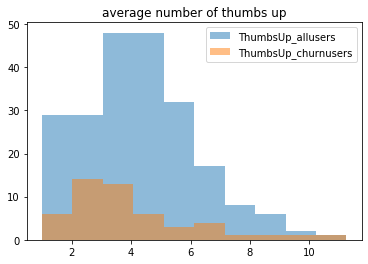

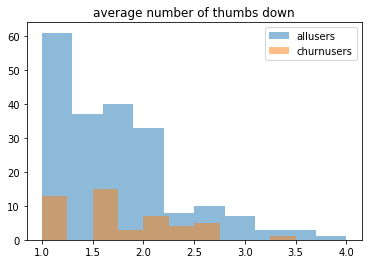

In [49]:
x = avg_thumbsup.toPandas().avg_ThumbsUp_day
y = churn_avg_thumbsup.toPandas().avg_ThumbsUp_day
plt.hist(x,alpha = 0.5,label="ThumbsUp_allusers")
plt.hist(y,alpha = 0.5,label="ThumbsUp_churnusers")
plt.legend(loc='upper right')
plt.title("average number of thumbs up")
plt.show()

x = avg_thumbsdown.toPandas().avg_ThumbsDown_day
y = churn_avg_thumbsdown.toPandas().avg_ThumbsDown_day
plt.hist(x,label="allusers",alpha = 0.5)
plt.hist(y,alpha = 0.5,label="churnusers")
plt.legend(loc='upper right')
plt.title("average number of thumbs down")
plt.show()


### 2.2.10 Churn vs. number of friends added

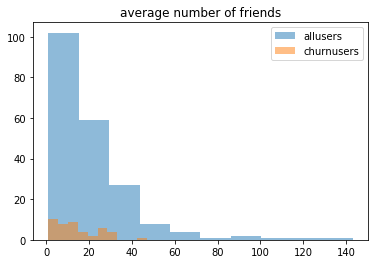

count    44.000000
mean     14.454545
std      10.712858
min       1.000000
25%       6.000000
50%      12.500000
75%      21.250000
max      47.000000
Name: num_friends, dtype: float64

In [50]:
num_friends = df.filter(df.page=='Add Friend')\
        .groupBy('userId').count()\
        .withColumnRenamed("count","num_friends")

churn_num_friends = num_friends.filter(num_friends.userId.isin(churn_userlist))
x = num_friends.toPandas().num_friends
y =churn_num_friends.toPandas().num_friends
plt.hist(x,label="allusers",alpha = 0.5)
plt.hist(y,alpha = 0.5,label="churnusers")
plt.legend(loc='upper right')
plt.title("average number of friends")
plt.show()


churn_num_friends.toPandas().num_friends.describe()

In [51]:
num_friends.toPandas().num_friends.describe()

count    206.000000
mean      20.762136
std       20.646779
min        1.000000
25%        7.000000
50%       16.000000
75%       28.000000
max      143.000000
Name: num_friends, dtype: float64

### 2.2.11 Churn vs. help requested

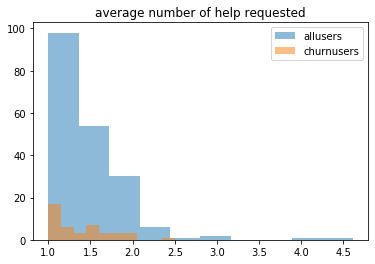

count    193.000000
mean       1.437411
std        0.500030
min        1.000000
25%        1.000000
50%        1.333333
75%        1.666667
max        4.610169
Name: avg_help_day, dtype: float64

In [52]:
num_requesthelp = df.filter(df.page=='Help')\
        .select('userId', 'page', 'date')\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'num_help')
avg_requesthelp = num_requesthelp.groupBy('userId')\
        .agg({'num_help':'mean'})\
        .withColumnRenamed('avg(num_help)', 'avg_help_day')


churn_avg_requesthelp = avg_requesthelp.filter(avg_requesthelp.userId.isin(churn_userlist))
x = avg_requesthelp.toPandas().avg_help_day
y =churn_avg_requesthelp.toPandas().avg_help_day
plt.hist(x,alpha = 0.5,label="allusers")
plt.hist(y,alpha = 0.5,label="churnusers")
plt.legend(loc='upper right')
plt.title("average number of help requested")
plt.show()


avg_requesthelp.toPandas().avg_help_day.describe()

In [53]:
churn_avg_requesthelp.toPandas().avg_help_day.describe()

count    43.000000
mean      1.351347
std       0.378151
min       1.000000
25%       1.000000
50%       1.250000
75%       1.527778
max       2.500000
Name: avg_help_day, dtype: float64

### 2.2.12 Churn vs. total length

/Users/leec/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/leec/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


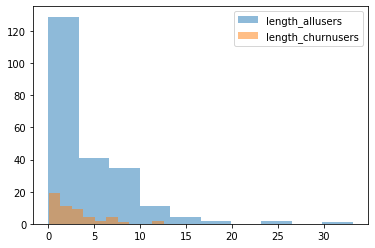

count    52.000000
mean      2.900238
std       2.964453
min       0.034819
25%       0.609105
50%       1.868152
75%       3.932089
max      12.575293
Name: total_lengh_minutes, dtype: float64

In [54]:
# total length in minutes of visit 
total_length = df.groupBy('userId').agg(Fsum('length')/60000).withColumnRenamed("(sum(length) / 60000)","total_lengh_minutes")

churn_total_length = total_length.filter(total_length.userId.isin(churn_userlist))
x = total_length.toPandas().total_lengh_minutes
y = churn_total_length.toPandas().total_lengh_minutes

plt.hist(x,alpha = 0.5,label="length_allusers")
plt.hist(y,alpha = 0.5,label="length_churnusers")
plt.legend(loc='upper right')
plt.show()

churn_total_length.toPandas().total_lengh_minutes.describe()

In [55]:
total_length.toPandas().total_lengh_minutes.describe()

count    225.000000
mean       4.209305
std        4.589940
min        0.011528
25%        0.960553
50%        2.801563
75%        6.540025
max       33.185915
Name: total_lengh_minutes, dtype: float64

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [56]:
# select relevant columns for modeling and join features
# Churn variable is our label variable, 
# as features I select the following variables created in the previous part to set as features in my model
# 1.level of user free or pay
# 2. status of user: if they considered cancellation or downgrade
# 3. avg_session - number of sessions per user
# 4. avg_songs_period - average number of songs users listen to between visiting our home page
# 5. avg_session_user - average session time in minutes per user 
# 6. max_session_user - average maximum time in minutes of sessions per user 
# 7. min_session_user - average minimum time in minutes of sessions per user 
# 8. avg_songs_playlist_session - average number of songs added to playlist per session 
# 9. avg_ThumbsUp_day - average number of thumbsup counted per day
# 10. avg_ThumbsDown_day - average number of thumbsdown counted per day
# 11. num_friends - average number of friends per user
# 12. avg_help_day - average number of help requested counted per day
# 13. total_length - average total length in minutes per visit 

df1 = df.select(["userId","free","paid","submit_cancel",
                            "submit_downgrade","visit_cancel","visit_downgrade"])\
    .join(avg_session,on="userId",how="left")\
    .join(avg_num_songs,on="userId",how="left")\
    .join(session_user,on="userId",how="left")\
    .join(avg_playlist,on="userId",how="left")\
    .join(avg_thumbsup,on="userId",how="left")\
    .join(avg_thumbsdown,on="userId",how="left")\
    .join(num_friends,on="userId",how="left")\
    .join(avg_requesthelp,on="userId",how="left")\
    .join(total_length,on="userId",how="left") 

df1.printSchema()

root
 |-- userId: string (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- submit_cancel: integer (nullable = true)
 |-- submit_downgrade: integer (nullable = true)
 |-- visit_cancel: integer (nullable = true)
 |-- visit_downgrade: integer (nullable = true)
 |-- avg_session: double (nullable = true)
 |-- avg_songs_period: double (nullable = true)
 |-- submit_cancel: integer (nullable = true)
 |-- avg_session_user: double (nullable = true)
 |-- max_session_user: double (nullable = true)
 |-- min_session_user: double (nullable = true)
 |-- avg_songs_playlist_session: double (nullable = true)
 |-- avg_ThumbsUp_day: double (nullable = true)
 |-- submit_cancel: integer (nullable = true)
 |-- avg(submit_cancel): double (nullable = true)
 |-- avg_ThumbsDown_day: double (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- avg_help_day: double (nullable = true)
 |-- total_lengh_minutes: double (nullable = true)



### 3.1. Define function for data preparation

In [2]:
def data_preparation(df):
    '''
    Load dataset and create df with all new features
    
    Resulting DF Strucutre:
    
    root
     |-- userId: string 
     |-- free: integer 
     |-- paid: integer 
     |-- submit_downgrade_user: long 
     |-- submit_cancel_user: long 
     |-- visit_cancel_user: long 
     |-- visit_downgrade_user: long 
     |-- submit_upgrade_user: long 
     |-- visit_upgrade_user: long 
     |-- avg_session_day: double
     |-- avg_songs_period: double 
     |-- avg_session_user: double 
     |-- max_session_user: double 
     |-- min_session_user: double 
     |-- avg_songs_playlist_session: double 
     |-- avg_ThumbsUp_day: double 
     |-- avg_ThumbsDown_day: double 
     |-- num_friends: long
     |-- avg_help_day: double
     |-- total_length: double

    Inputs
        uncleaned df 
    Outputs
        cleaned df prepared for machine learning model
        
    '''
    
    # drop all blank userIds and sessionIds
    df = df.filter(df.userId != "")
    
    #define custom functions
    churn = udf(lambda x : int(x == 'Cancel'), IntegerType())
    downgrade = udf(lambda x : int(x == 'Downgrade'), IntegerType())
    downgraded = udf(lambda x: 1 if (x == "Submit Downgrade") else 0, IntegerType())
    submit_cancel = udf(lambda x : int(x == 'Cancellation Confirmation'), IntegerType())
    upgrade = udf(lambda x : int(x == 'Upgrade'), IntegerType())
    upgraded = udf(lambda x : int(x == 'Submit Upgrade'), IntegerType())
    free = udf(lambda level : int(level == 'free'), IntegerType())
    paid = udf(lambda level : int(level == 'paid'), IntegerType())
    todate = udf(lambda x :  dt.datetime.fromtimestamp(x/1000), DateType())
    gethour = udf(lambda x :  dt.datetime.fromtimestamp(x/1000).hour, IntegerType())
    homevisit = udf(lambda ishome : int(ishome == 'Home'), IntegerType())
    playlist = udf(lambda playlist : int(playlist == 'Add to Playlist'), IntegerType())

    
    #define windows
    window_userdate = Window.partitionBy(["userId","date"])
    window_usertime= Window \
                    .partitionBy('userId') \
                    .orderBy(desc('ts')) \
                    .rangeBetween(Window.unboundedPreceding, 0)
    
    window_session= Window.partitionBy('userId','sessionId') \
                    .orderBy(df['ts'].desc()) \
                    .rangeBetween(Window.unboundedPreceding,0)
    window_usersession= Window \
                    .partitionBy('userId','sessionId')
    window_user= Window \
                .partitionBy('userId')
        
    # Convert timestamp to datetime format
    df = df.withColumn('date',todate('ts'))\
            .withColumn('year',year(todate('ts')))\
            .withColumn('month',month(todate('ts')))\
            .withColumn('day',dayofmonth(todate('ts')))\
            .withColumn('hour',gethour('ts'))\
            .withColumn('weekday',dayofweek(todate('ts')))


    ## dummy level
    df = df.withColumn('free',free('level'))\
            .withColumn('paid',paid('level'))    
    
    ## define churn 
    df = df.withColumn("submit_cancel", submit_cancel("page")) \
            .withColumn("submit_downgrade",downgraded("page"))\
            .withColumn("submit_upgrade",upgraded("page"))\
            .withColumn("visit_cancel",churn("page"))\
            .withColumn("visit_downgrade",downgrade("page"))\
            .withColumn("visit_upgrade",upgrade("page"))
    
    ### avg songs per period between each homevisit
    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('level','userId', 'page', 'ts','date','hour','submit_cancel','submit_downgrade','visit_cancel','visit_downgrade') \
        .withColumn('homevisit', homevisit(col('page'))) \
        .withColumn('period', Fsum('homevisit').over(window_usertime))
    num_songs = cusum.filter(cusum.page == 'NextSong') \
        .groupBy('userId', 'period') \
        .agg({'period':'count'})\
        .withColumnRenamed('count(period)','num_songs_period')
    avg_num_songs = num_songs.groupBy('userId').agg({'num_songs_period':'avg'})\
            .withColumnRenamed('avg(num_songs_period)','avg_songs_period')
    

    ## number of sessions per user per day
    num_session = df.withColumn("num_session_date",count("sessionId").over(window_userdate))\
                .dropDuplicates()\
                .orderBy(desc("num_session_date"))
    #average number of sessions per userId
    avg_session = num_session.groupby(["userId"])\
                .agg({"num_session_date":'mean'})\
                .withColumnRenamed("avg(num_session_date)","avg_session_day")

    # avg of mean, max, min per session per user
    session_len = df\
                .withColumn('sessiontime',
                ((func.max(df['ts']/1000).over(window_session) - (func.min(df['ts']/1000).over(window_session)))))

    session = session_len\
                .withColumn("avg_session",mean('sessiontime').over(window_usersession))\
                .withColumn("max_session",max('sessiontime').over(window_usersession))\
                .withColumn("min_session",min('sessiontime').over(window_usersession))
    session_user = session\
                .withColumn("avg_sessiontime_user",mean('sessiontime').over(window_user))\
                .withColumn("max_sessiontime_user",max('sessiontime').over(window_user))\
                .withColumn("min_sessiontime_user",min('sessiontime').over(window_user))\
                .select(["userId","avg_sessiontime_user","max_sessiontime_user","min_sessiontime_user"]).dropDuplicates()

    # average number of songs added to playlist per user per session
    num_playlist =df.withColumn('playlist', playlist(col('page')))\
        .groupBy('userId','sessionId') \
        .agg({'playlist':'count'}) \
        .withColumnRenamed('count(playlist)','number_songs_playlist')
    avg_playlist = num_playlist.groupby("userId").agg({"number_songs_playlist":"mean"})\
                .withColumnRenamed('avg(number_songs_playlist)','avg_songs_playlist_session')
    
    # average thumbs up and down per day of each user 
    num_thumbsup = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'date')\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'num_thumbsup')
    avg_thumnsup = num_thumbsup.groupBy('userId')\
            .agg({'num_thumbsup':'mean'})\
            .withColumnRenamed('avg(num_thumbsup)', 'avg_ThumbsUp_day')

    num_thumbsdown = df.filter(df.page=='Thumbs Down')\
            .select('userId', 'page', 'date')\
            .groupBy('userId', 'date').agg({'page':'count'})\
            .withColumnRenamed('count(page)', 'num_thumbsdown')
    avg_thumbsdown = num_thumbsdown.groupBy('userId').mean()\
            .withColumnRenamed('avg(num_thumbsdown)', 'avg_ThumbsDown_day')
    
    # number of friends
    num_friends = df.filter(df.page=='Add Friend')\
                .groupBy('userId').count()\
                .withColumnRenamed('count', 'num_friends')
    
    # average number of help requested per day per user
    num_requesthelp = df.filter(df.page=='Help')\
        .select('userId', 'page', 'date')\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'num_help')
    avg_requesthelp = num_requesthelp.groupBy('userId')\
        .agg({'num_help':'mean'})\
        .withColumnRenamed('avg(num_help)', 'avg_help_day')
    
    # total length of session per user
    total_length = df.groupBy('userId')\
                .agg(Fsum('length'))\
                .withColumnRenamed('sum(length)','total_length')
    
    # select relevant columns for modeling and join features
    df_feature = df.select(["userId","free","paid","submit_cancel",
                            "submit_downgrade","visit_cancel","visit_downgrade"])\
        .join(avg_session,on="userId",how="left")\
        .join(avg_num_songs,on="userId",how="left")\
        .join(session_user,on="userId",how="left")\
        .join(avg_playlist,on="userId",how="left")\
        .join(avg_thumnsup,on="userId",how="left")\
        .join(avg_thumbsdown,on="userId",how="left")\
        .join(num_friends,on="userId",how="left")\
        .join(total_length,on="userId",how="left")\
        .join(avg_requesthelp,on="userId",how="left").dropDuplicates().fillna(0)
 
    
    return df_feature

In [3]:
######### Load data set and check 

## create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

## Load dataset  
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

## apply data_preparation function
df_clean = data_preparation(df)

## check if there is any null values
df_clean.toPandas().isnull().sum()

userId                        0
free                          0
paid                          0
submit_cancel                 0
submit_downgrade              0
visit_cancel                  0
visit_downgrade               0
avg_session_day               0
avg_songs_period              0
avg_sessiontime_user          0
max_sessiontime_user          0
min_sessiontime_user          0
avg_songs_playlist_session    0
avg_ThumbsUp_day              0
avg_ThumbsDown_day            0
num_friends                   0
total_length                  0
avg_help_day                  0
dtype: int64

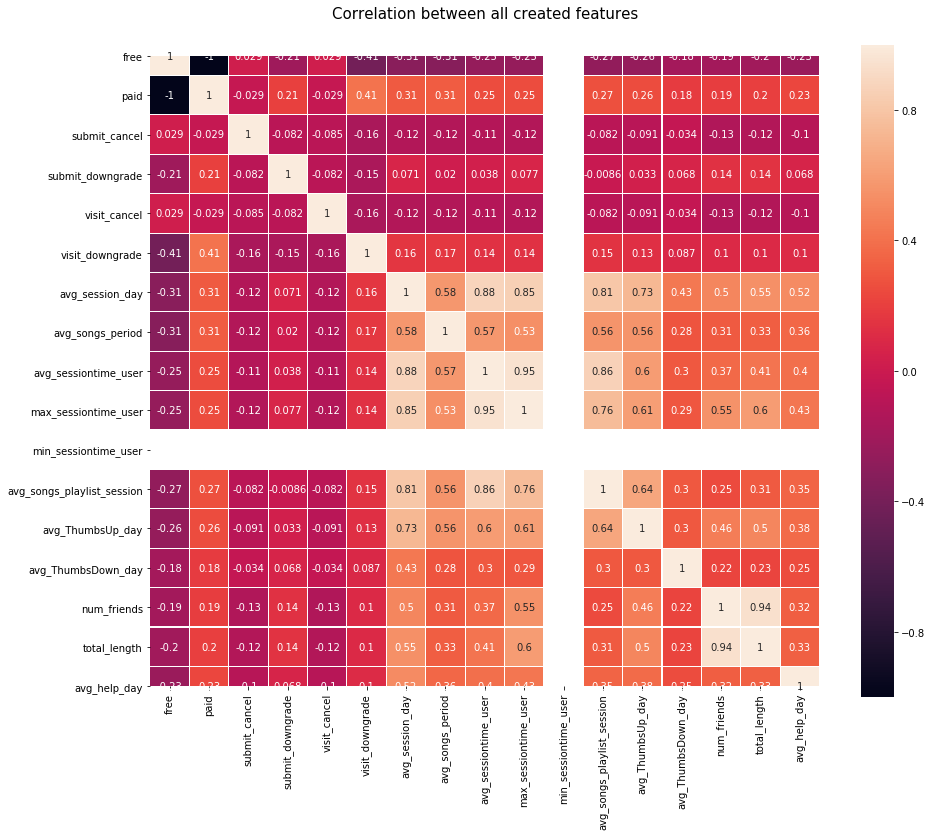

In [4]:
# correlation heatmap
plt.figure(figsize=(15,12))
plt.title('Correlation between all created features', y=1.05, size=15)
sns.heatmap(df_clean.toPandas().corr(),linewidths=0.1,vmax=1.0, 
            square=True,annot=True);

# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [5]:
#Put the features to be trained into a vector
features = df_clean.drop('userId', 'submit_cancel').columns
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")

# Use StandardScaler
stdscaler = StandardScaler(inputCol="NumFeatures", outputCol="features")

# Use MinMaxScaler
minmaxscaler = MinMaxScaler(inputCol="NumFeatures", outputCol="features")

### 4.1. Train Test Split
Break data set into 70% of training data and set aside 30%, set seed as 42.

In [6]:
# spilt data for Train and test 
train, test = df_clean.randomSplit([0.7, 0.3],seed = 42);

### 4.2. Modeling methods

In [9]:
#using five different modeling approaches 

# Logistic Regression
model_lr = LogisticRegression(featuresCol="features",labelCol = "submit_cancel")
# naive bayes
model_nb = NaiveBayes(featuresCol='features',labelCol = "submit_cancel")
# decision tree 
model_dtc = DecisionTreeClassifier(featuresCol='features',labelCol = "submit_cancel", seed=4)
# RandomForestClassifier
model_rf = RandomForestClassifier(featuresCol="features",labelCol = "submit_cancel")
# GBT Classifier
model_gbt = GBTClassifier(featuresCol="features",labelCol = "submit_cancel")

### 4.3. Build Pipeline

In [63]:
#Create Pipeline with standardscaled data 
pipeline_nb = Pipeline(stages=[assembler, stdscaler, model_nb]);
pipeline_lr = Pipeline(stages=[assembler, stdscaler, model_lr]);
pipeline_dtc = Pipeline(stages=[assembler, stdscaler, model_dtc]);
pipeline_rf = Pipeline(stages=[assembler, stdscaler, model_rf]);
pipeline_gbt = Pipeline(stages=[assembler, stdscaler, model_gbt])

### 4.4. Model fitting

In [64]:
# Fit model of each model
# logistic regression
start_lr = time.time()
model_lr_fitted = pipeline_lr.fit(train);
end_lr = time.time()
lr_time = end_lr - start_lr

print('Total training time for logistic regression: {} seconds'.format(lr_time))


Total training time for logistic regression: 610.585676908493 seconds


In [7]:
# model performance evaluation
def eval_model(model, test, metric):
    """ Calculate Model Scores metric
        Input: 
            model- trained model or pipeline object
            metric- the metric chosen to measure performance
            data - dataset for the evaluation
        Output:
            score
    """
    predictions = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol ="submit_cancel",metricName = metric)

    # find score
    score = evaluator.evaluate(predictions)
    #return score
    return score

In [67]:
lr_f1 = eval_model(model_lr_fitted, test,"f1")
lr_acc = eval_model(model_lr_fitted, test,"accuracy")
print('Logistic Regression - Accuracy: {}'.format(lr_acc),'Logistic Regression - F1 score: {}'.format(lr_f1))

Logistic Regression - Accuracy: 0.9025641025641026 Logistic Regression - F1 score: 0.8784974736194249


In [68]:
#  decision tree
start_dtc = time.time()
model_dtc_fitted = pipeline_dtc.fit(train);
end_dtc =  time.time()
dtc_time = end_dtc - start_dtc

print('Total training time for decision tree: {} seconds'.format(dtc_time))

# naive bayes
start_nb = time.time()
model_nb_fitted = pipeline_nb.fit(train);
end_nb = time.time()
nb_time = end_nb - start_nb

print('Total training time for naive bayes: {} seconds'.format(nb_time))

# random forest
start_rf =  time.time()
model_rf_fitted = pipeline_rf.fit(train);
end_rf =  time.time()
rf_time = end_rf - start_rf
print('Total training time for random forest: {} seconds'.format(rf_time))

# gradient-boosted tree
start_gbt =  time.time()
model_gbt_fitted = pipeline_gbt.fit(train)
end_gbt = time.time()
gbt_time = end_gbt - start_gbt

print('Total training time for gradient-boosted trees: {} seconds'.format(gbt_time))

Total training time for decision tree: 847.526419878006 seconds
Total training time for naive bayes: 556.0321972370148 seconds
Total training time for random forest: 846.4150269031525 seconds
Total training time for gradient-boosted trees: 640.139720916748 seconds


In [69]:
dtc_acc = eval_model(model_dtc_fitted, test,"accuracy")
dtc_f1 = eval_model(model_dtc_fitted, test,"f1")
print('Decision Tree - Accuracy: {}'.format(dtc_acc),'Decision Tree - F1 score: {}'.format(dtc_f1))

Decision Tree - Accuracy: 0.8717948717948718 Decision Tree - F1 score: 0.8550755180892166


In [70]:
nb_acc = eval_model(model_nb_fitted, test,"accuracy")
nb_f1 = eval_model(model_nb_fitted, test,"f1")
print('Naive Bayes - Accuracy: {}'.format(nb_acc),'Naive Bayes - F1 score: {}'.format(nb_f1))

Naive Bayes - Accuracy: 0.9128205128205128 Naive Bayes - F1 score: 0.8761119131092321


In [71]:
rf_acc = eval_model(model_rf_fitted, test,"accuracy")
rf_f1 = eval_model(model_rf_fitted, test,"f1")
print('Random Forest - Accuracy: {}'.format(rf_acc),'Random Forest - F1 score: {}'.format(rf_f1))

Random Forest - Accuracy: 0.9179487179487179 Random Forest - F1 score: 0.8786781845605375


In [72]:
gbt_acc =eval_model(model_gbt_fitted, test,"accuracy")
gbt_f1 =eval_model(model_gbt_fitted, test,"f1")

print('Gradient-Boosted Tree - Accuracy: {}'.format(gbt_acc),'Gradient-Boosted Tree - F1 score: {}'.format(gbt_f1))

Gradient-Boosted Tree - Accuracy: 0.8512820512820513 Gradient-Boosted Tree - F1 score: 0.844207685204915


In [73]:
result = {'Model': ['Logistic Regression','Decision Tree','Naive Bayes','Random Forest','Grandient-Boosted Tree'],
          'F1': [lr_f1,dtc_f1,nb_f1,rf_f1,gbt_f1],
          'Accuracy':[lr_acc,dtc_acc,nb_acc,rf_acc,gbt_acc],
          'Training Time':[lr_time,dtc_time,nb_time,rf_time,gbt_time]}
result = pd.DataFrame(result)
result

,Model,F1,Accuracy,Training Time
0,Logistic Regression,0.878497,0.902564,610.585677
1,Decision Tree,0.855076,0.871795,847.526420
2,Naive Bayes,0.876112,0.912821,556.032197
3,Random Forest,0.878678,0.917949,846.415027
4,Grandient-Boosted Tree,0.844208,0.851282,640.139721


In [162]:
feature_coeff_rf = model_rf_fitted.stages[-1].featureImportances
featureImp_rf = pd.DataFrame(list(zip(features, feature_coeff_rf)), columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)

featureImp_rf

,Feature,FeatureImportances
11,avg_ThumbsUp_day,0.145222
5,avg_session_day,0.142903
13,num_friends,0.104816
14,total_length,0.103461
12,avg_ThumbsDown_day,0.090038
6,avg_songs_period,0.089403
7,avg_sessiontime_user,0.074967
10,avg_songs_playlist_session,0.073263
8,max_sessiontime_user,0.042581
0,free,0.042361


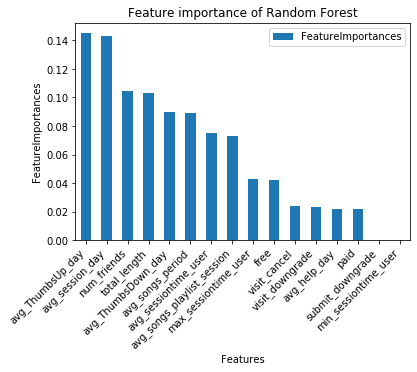

In [164]:
featureImp_rf.plot.bar(x='Feature', y='FeatureImportances')
plt.title('Feature importance of Random Forest')
plt.xlabel('Features')
plt.ylabel('FeatureImportances')
plt.xticks(rotation=45, ha='right')
plt.show()

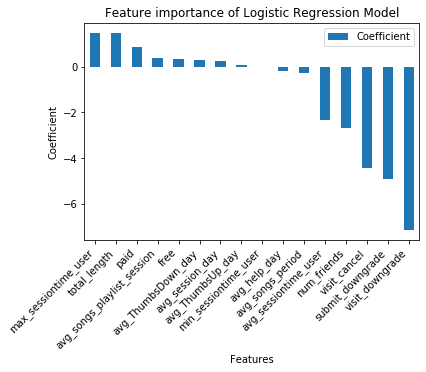

In [146]:
feature_coeff_lr = model_lr_fitted.stages[-1].coefficients
featureImp_lr = pd.DataFrame(list(zip(features, feature_coeff_lr)), columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)

featureImp_lr.plot.bar(x='Feature', y='Coefficient')
plt.title('Feature importance of Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

### 4.5. Tune Model

In [11]:
#Crossvalidation Logistic Regression
model_lr = LogisticRegression(featuresCol="features",labelCol="submit_cancel", maxIter=10)

#Create Pipeline with minmaxscaler data 
pipeline_lr_minmax = Pipeline(stages=[assembler, minmaxscaler, model_lr]);

paramGrid = ParamGridBuilder() \
    .addGrid(model_lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(model_lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr_minmax,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="submit_cancel"),
                          numFolds=3)
cvModel_start_lr = time.time()
cvModel_lr = crossval_lr.fit(train)
cvModel_lr_acc = eval_model(cvModel_lr, test,"accuracy")
cvModel_lr_f1 =eval_model(cvModel_lr, test,"f1")
print('Logistic Regression - Accuracy: {}'.format(cvModel_lr_acc),'Logistic Regression - F1 score: {}'.format(cvModel_lr_f1))

cvModel_end_lr = time.time()
cvModel_lr_time = cvModel_end_lr - cvModel_start_lr
print('Total training time for logistic regression: {} seconds'.format(cvModel_lr_time))


Logistic Regression - Accuracy: 0.9179487179487179 Logistic Regression - F1 score: 0.8786781845605375
Total training time for logistic regression: 3067.404175043106 seconds


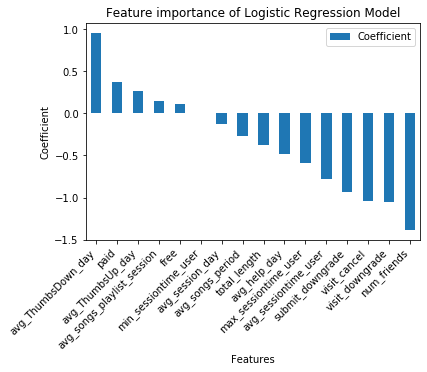

In [12]:
## Feature importances
feature_coeff = cvModel_lr.bestModel.stages[-1].coefficients
featureImp = pd.DataFrame(list(zip(features, feature_coeff)), columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)

featureImp.plot.bar(x='Feature', y='Coefficient')
plt.title('Feature importance of Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
#Crossvalidation Random Forest

model_rf = RandomForestClassifier(featuresCol="features",labelCol="submit_cancel")
pipeline_rf_minmax = Pipeline(stages=[assembler, minmaxscaler, model_rf]);

paramGrid = ParamGridBuilder() \
    .addGrid(model_dtc.impurity,['entropy', 'gini']) \
    .addGrid(model_dtc.maxDepth,[5,10,20]) \
    .build()
crossval_rf = CrossValidator(estimator=pipeline_rf_minmax,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol = "submit_cancel"),
                          numFolds=3)

cvModel_start_rf = time.time()
cvModel_rf = crossval_rf.fit(train)
cvModel_rf_acc = eval_model(cvModel_rf, test,"accuracy")
cvModel_rf_f1 =eval_model(cvModel_rf, test,"f1")
print('Random Forest - Accuracy: {}'.format(cvModel_rf_acc),'Random Forest - F1 score: {}'.format(cvModel_rf_f1))

cvModel_end_rf = time.time()
cvModel_rf_time = cvModel_end_rf - cvModel_start_rf
print('Total training time for Random Forest: {} seconds'.format(cvModel_rf_time))



Random Forest - Accuracy: 0.9076923076923077 Random Forest - F1 score: 0.8735318444995864
Total training time for Random Forest: 3240.152140855789 seconds


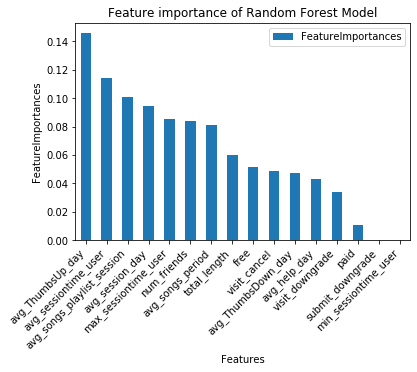

In [14]:
## Feature importances
feature_coeff_rf = cvModel_rf.bestModel.stages[-1].featureImportances
featureImp_rf = pd.DataFrame(list(zip(features, feature_coeff_rf)), columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)

featureImp_rf.plot.bar(x='Feature', y='FeatureImportances')
plt.title('Feature importance of Random Forest Model')
plt.xlabel('Features')
plt.ylabel('FeatureImportances')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
# Performance Comparison
cvModel_result = {'Model': ['Logistic Regression','Random Forest'],
          'F1': [cvModel_lr_f1,cvModel_rf_f1],
          'Accuracy':[cvModel_lr_acc,cvModel_rf_acc],
          'Training Time':[cvModel_lr_time,cvModel_rf_time]}
cvModel_result = pd.DataFrame(cvModel_result)
cvModel_result

,Model,F1,Accuracy,Training Time
0,Logistic Regression,0.878678,0.917949,3067.404175
1,Random Forest,0.873532,0.907692,3240.152141


In [ ]:
#Crossvalidation Decision Tree

model_dtc = DecisionTreeClassifier(featuresCol="features",labelCol="submit_cancel")

paramGrid = ParamGridBuilder() \
    .addGrid(model_dtc.impurity,['entropy', 'gini']) \
    .addGrid(model_dtc.maxDepth,[2, 4,6]) \
    .build()
crossval_dtc = CrossValidator(estimator=pipeline_dtc_minmax,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol = "submit_cancel"),
                          numFolds=3)

cvModel_start_dtc = time.time()
cvModel_dtc = crossval_dtc.fit(train)
cvModel_dtc_acc = eval_model(cvModel_dtc, test,"accuracy")
cvModel_dtc_f1 =eval_model(cvModel_dtc, test,"f1")
print('Decision Tree - Accuracy: {}'.format(cvModel_dtc_acc),'Decision Tree - F1 score: {}'.format(cvModel_dtc_f1))

cvModel_end_dtc = time.time()
cvModel_dtc_time = cvModel_end_dtc - cvModel_start_dtc
print('Total training time for decision tree: {} seconds'.format(cvModel_dtc_time))


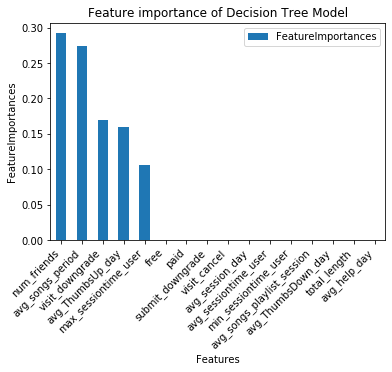

In [172]:
## Feature importances
feature_coeff_dtc = cvModel_dtc.bestModel.stages[-1].featureImportances
featureImp_dtc = pd.DataFrame(list(zip(features, feature_coeff_dtc)), columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)

featureImp_dtc.plot.bar(x='Feature', y='FeatureImportances')
plt.title('Feature importance of Decision Tree Model')
plt.xlabel('Features')
plt.ylabel('FeatureImportances')
plt.xticks(rotation=45, ha='right')
plt.show()

## 5. Conclusion

The results indicate the length of a session of a user and also how the user interacts with the song ( listen to a song, rate the song through thumbs up / down or added to their playlist) are good indicators for prediction churn. Overall we have in our approaches relatively good performance, the F1 score is in each method over 0.84. For validation purposes, I will suggest expanding the train and test dataset in the next step to see if the performance remains stable.


The most challenging part of this project is to generate relevant features to perform a significant result for prediction. This process is crucial and took a great part of the effort for me in this project. There is still room for improvement of features in our model. With sufficient knowledge and expertise, there should be more other relevant features to add, which are reasonable for communication with the stakeholders.


For further improvements, a larger dataset will be helpful to get an enhanced exploratory analysis of the churned users. Optimized data preparation can complement feature engineering, as well as performing a comprehensive grid search by using cloud computing techniques such as AWS or IBM can improve model training and testing.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.